In [33]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.metrics import make_scorer

# Adding custom libraries
from src import categorical as le
from src import feature_selector as fs
from src import metrics as mm
from src import cross_validation as cv
from src import dispatcher
from src import param_tuning

In [34]:
TARGET = 'SalePrice'
NUM_FOLDS = 5
SHUFFLE=False
FOLD_MAPPING = {i: [j for j in range(NUM_FOLDS) if j != i] for i in range(NUM_FOLDS)}
MODEL = 'CatBoostRegressor'

In [35]:
df_tr = pd.read_csv("input/train.csv")

In [36]:
cval = cv.CrossValidation(df_tr, target_cols=[TARGET], num_folds=NUM_FOLDS, problem_type="single_col_regression", shuffle=SHUFFLE, random_state=42)
df_split = cval.split()

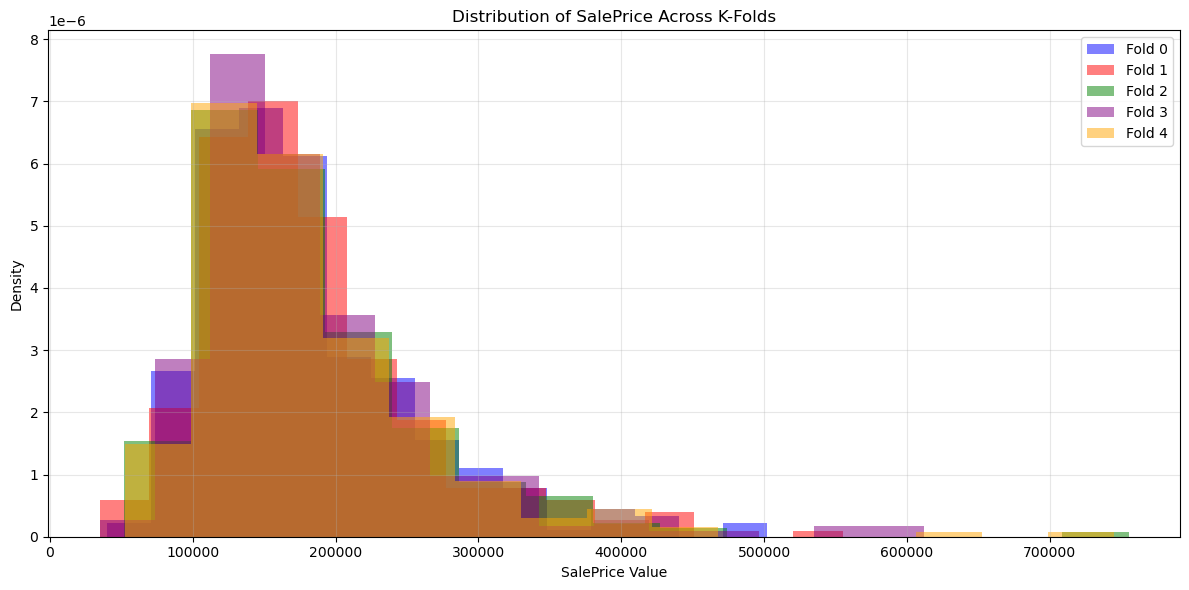


Target value statistics by fold:
Fold 0:
  Mean: 179358.91
  Std: 74814.60
  Count: 292
Fold 1:
  Mean: 180020.16
  Std: 77215.04
  Count: 292
Fold 2:
  Mean: 181721.82
  Std: 80287.07
  Count: 292
Fold 3:
  Mean: 182092.07
  Std: 82678.02
  Count: 292
Fold 4:
  Mean: 181413.02
  Std: 82436.20
  Count: 292


In [44]:
# Create bins for the target variable
n_bins = 15  # You can adjust the number of bins
target_bins = pd.cut(df_split[TARGET], bins=n_bins)

# Add the binned values to the dataframe
df_split['target_bin'] = target_bins

# Create the plot
plt.figure(figsize=(12, 6))

# Colors for different folds
colors = ['blue', 'red', 'green', 'purple', 'orange']

# Plot histogram for each fold
for fold in range(NUM_FOLDS):
    fold_data = df_split[df_split['kfold'] == fold][TARGET]
    plt.hist(
        fold_data,
        bins=n_bins,
        alpha=0.5,
        label=f'Fold {fold}',
        color=colors[fold % len(colors)],
        density=True  # Normalize to show density instead of counts
    )

plt.xlabel(f'{TARGET} Value')
plt.ylabel('Density')
plt.title(f'Distribution of {TARGET} Across K-Folds')
plt.legend()
plt.grid(True, alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Optional: Print some statistics
print("\nTarget value statistics by fold:")
for fold in range(NUM_FOLDS):
    fold_data = df_split[df_split['kfold'] == fold][TARGET]
    print(f"Fold {fold}:")
    print(f"  Mean: {fold_data.mean():.2f}")
    print(f"  Std: {fold_data.std():.2f}")
    print(f"  Count: {len(fold_data)}")


In [43]:

regression_metrics = mm.RegressionMetrics()
rmsle_scorer = make_scorer(regression_metrics._rmsle, greater_is_better=False)


# Load data
df = df_split.drop(columns=[TARGET, 'kfold', 'id'], axis=1, errors='ignore')
X = df
y = df_split[TARGET]

# Generate custom CV splits from the 'kfold' column
kfold_column = df_split['kfold']
n_splits = kfold_column.nunique()  # Number of unique folds (e.g., 5)
cv_folds = []
for fold in range(n_splits):
    # Test indices: rows where kfold == current fold
    test_idx = df_split.index[kfold_column == fold].tolist()
    # Train indices: all other rows
    train_idx = df_split.index[kfold_column != fold].tolist()
    cv_folds.append((train_idx, test_idx))

# Define configurations
ordinal_configs = [
    ('BsmtQual', ['nan', 'NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('BsmtCond', ['nan', 'NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('HeatingQC', ['nan', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('KitchenQual', ['nan', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('FireplaceQu', ['nan', 'NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('GarageQual', ['nan', 'NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('GarageCond', ['nan', 'NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('PoolQC', ['nan', 'NA', 'Fa', 'TA', 'Gd', 'Ex']),
    ('Street', ['Grvl', 'Pave']),
    ('Alley', ['nan', 'Grvl', 'Pave']),
    ('Utilities', ['NoSeWa', 'NoSewr', 'AllPub']),
    ('CentralAir', ['N', 'Y'])
]

one_hot_cols = [col for col in df.select_dtypes(include=['object']).columns 
                if col not in [cfg[0] for cfg in ordinal_configs] + ['YearRemodAdd_binned', 'GarageYrBlt_binned']]

binary_cols = []
auto_cols = []

numeric_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns 
                if col not in ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 
                               'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
                               'Fireplaces', 'GarageYrBlt', 'GarageCars', 'EnclosedPorch', '3SsnPorch', 
                               'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']]

impute_dict = {
    'LotFrontage': 0,
    'MasVnrArea': 0
}

binning_configs = {
    'YearRemodAdd': {
        'bins': [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010],
        'labels': ['1900-09', '1910-19', '1920-29', '1930-39', '1940-49', '1950-59', 
                   '1960-69', '1970-79', '1980-89', '1990-99', '2000-09'],
        'fill': 'no_remod'
    },
    'GarageYrBlt': {
        'bins': [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010],
        'labels': ['1900-09', '1910-19', '1920-29', '1930-39', '1940-49', '1950-59', 
                   '1960-69', '1970-79', '1980-89', '1990-99', '2000-09'],
        'fill': 'no_garage'
    }
}


# Define the pipeline
preprocessor = le.Preprocessor(
    ordinal_configs=ordinal_configs,
    one_hot_cols=one_hot_cols,
    binary_cols=binary_cols,
    auto_cols=auto_cols,
    numeric_cols=numeric_cols,
    impute_dict=impute_dict,
    binning_configs=binning_configs,
    cardinality_threshold=5
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('correlation_threshold', le.CorrelationThreshold(threshold=0.94)),
    ('regressor', CatBoostRegressor(verbose=0, random_state=42))
])

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'correlation_threshold__threshold': stats.uniform(0.85, 0.1),
    'regressor__iterations': stats.randint(500, 1500),
    'regressor__learning_rate': stats.uniform(0.01, 0.2),
    'regressor__depth': stats.randint(4, 10),
    'regressor__l2_leaf_reg': stats.uniform(1, 10)
}

# Optimize with RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=cv_folds,
    scoring=rmsle_scorer,
    random_state=42,
    n_jobs=-1,
    error_score='raise',
    verbose=1
)

# Fit the model
random_search.fit(X, y)

# Print best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best RMSLE:", -random_search.best_score_)

# Use the best model for predictions
best_model = random_search.best_estimator_



Fitting 5 folds for each of 50 candidates, totalling 250 fits


Best parameters: {'correlation_threshold__threshold': 0.9109564333979897, 'regressor__depth': 5, 'regressor__iterations': 719, 'regressor__l2_leaf_reg': 1.5147875124998935, 'regressor__learning_rate': 0.06572929284732229}
Best RMSLE: 0.12130209135771777


In [39]:
import joblib
import json

# --- Save Phase (after random_search.fit(X, y)) ---
# Save model
joblib.dump(best_model, 'models/best_model_randomsearch_catboost1.pkl')

# Save schema with dtypes as strings
schema = {
    'columns': {col: str(dtype) for col, dtype in X.dtypes.to_dict().items()},
    'categorical_values': {col: df[col].unique().tolist() for col in df.select_dtypes(include=['object']).columns}
}
with open('models/data_schema_randomsearch_catboost1.json', 'w') as f:
    json.dump(schema, f)

# Save training data
df_split.to_csv('input/training_data_folds1.csv', index=False)

# Save config
config = {'random_state': 42}
with open('models/config.json', 'w') as f:
    json.dump(config, f)



In [40]:


# --- Load and Predict Phase ---
# Load model
best_model = joblib.load('models/best_model_randomsearch_catboost1.pkl')

# Load schema
with open('models/data_schema_randomsearch_catboost1.json', 'r') as f:
    schema = json.load(f)

# Load test data
test_df = pd.read_csv('input/test.csv')

# Preserve 'id' column before schema validation
if 'id' in test_df.columns:
    id_column = test_df['id'].copy()  # Save 'id' for later use
else:
    raise ValueError("Test data does not contain an 'id' column")

# Validate schema
expected_columns = set(schema['columns'].keys())
test_columns = set(test_df.columns)
missing_cols = expected_columns - test_columns
extra_cols = test_columns - expected_columns
if missing_cols:
    print(f"Warning: Test data is missing columns: {missing_cols}, proceeding anyway")
if extra_cols:
    print(f"Warning: Dropping extra columns: {extra_cols}")
    test_df = test_df[list(expected_columns & test_columns)]

impute_dict = {
    'LotFrontage': 0,
    'MasVnrArea': 0
    # Add more columns if known from training
}
for col in test_df.columns:
    if col in impute_dict:
        test_df[col] = test_df[col].fillna(impute_dict[col])
    elif test_df[col].dtype in ['float64', 'int64']:  # Default imputation for numeric
        test_df[col] = test_df[col].fillna(0)  # Or use median, mean, etc.

# 6. Ensure data types
for col, dtype_str in schema['columns'].items():
    if col in test_df.columns:
        test_df[col] = test_df[col].astype(pd.api.types.pandas_dtype(dtype_str))

# 7. Make predictions
predictions = best_model.predict(test_df)

output_df = pd.DataFrame({
    'id': id_column,           # Use the preserved 'id' column
    TARGET: predictions        # Rename 'predictions' to TARGET
})

# 7. Save predictions
output_df.to_csv('models/preds_randomsearch_catboost1.csv', index=False)

# Print sample predictions
print("Sample predictions:")
print(predictions[:5])

Sample predictions:
[130131.59063203 171673.81022579 186324.85212783 187451.38873973
 186266.80168092]
